In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --user imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import imblearn
print(imblearn.__version__)

0.12.4


In [4]:
import os
import random
import csv
import zlib
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage
from skimage.transform import resize
from tqdm import tqdm

# Use TensorFlow's Keras
from tensorflow.keras import backend as K
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Activation,
    Flatten,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    KFold,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from glob import glob

# For inline plotting in Jupyter notebooks
%matplotlib inline


In [5]:
train_dir = "alpha_train"
test_dir = "alpha_test"


In [6]:
import os

train_dir = "alpha_train"
print(os.listdir(train_dir))
print("\n")
test_dir = "alpha_test"
print(os.listdir(test_dir))

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


['A_test.jpg', 'B_test.jpg', 'C_test.jpg', 'D_test.jpg', 'E_test.jpg', 'F_test.jpg', 'G_test.jpg', 'H_test.jpg', 'I_test.jpg', 'J_test.jpg', 'K_test.jpg', 'L_test.jpg', 'M_test.jpg', 'nothing_test.jpg', 'N_test.jpg', 'O_test.jpg', 'P_test.jpg', 'Q_test.jpg', 'R_test.jpg', 'space_test.jpg', 'S_test.jpg', 'T_test.jpg', 'U_test.jpg', 'V_test.jpg', 'W_test.jpg', 'X_test.jpg', 'Y_test.jpg', 'Z_test.jpg']


In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import skimage.transform
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

imageSize = 50
train_dir = "alpha_train" 
test_dir = "alpha_test"

def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    
    for folderName in os.listdir(folder):
        # Skip hidden files/folders
        if not folderName.startswith('.'):
            # Map folder names to labels
            if len(folderName) == 1 and folderName.isalpha():
                label = ord(folderName) - ord('A')  # For 'A' to 'Z'
            elif folderName == 'del':
                label = 26
            elif folderName == 'nothing':
                label = 27
            elif folderName == 'space':
                label = 28
            else:
                label = 29  # For 'others'

            # Path to the subdirectory
            subfolder_path = os.path.join(folder, folderName)
            for image_filename in tqdm(os.listdir(subfolder_path)):
                img_file_path = os.path.join(subfolder_path, image_filename)
                img_file = cv2.imread(img_file_path)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

X_train, y_train = get_data(train_dir)
# X_test, y_test = get_data(test_dir)  # Too few images

# Split the training set into a new training set and a validation set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

# Encode labels to hot vectors
y_trainHot = to_categorical(y_train, num_classes=30)
y_testHot = to_categorical(y_test, num_classes=30)


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:42<00:00, 69.82it/s]


In [8]:
# Shuffle data to permit further subsampling
from sklearn.utils import shuffle
X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_train = X_train[:30000]
X_test = X_test[:30000]
y_trainHot = y_trainHot[:30000]
y_testHot = y_testHot[:30000]

# Step 3: Vizualize Data

The min/max pixel values are already scaled between 0 and 1

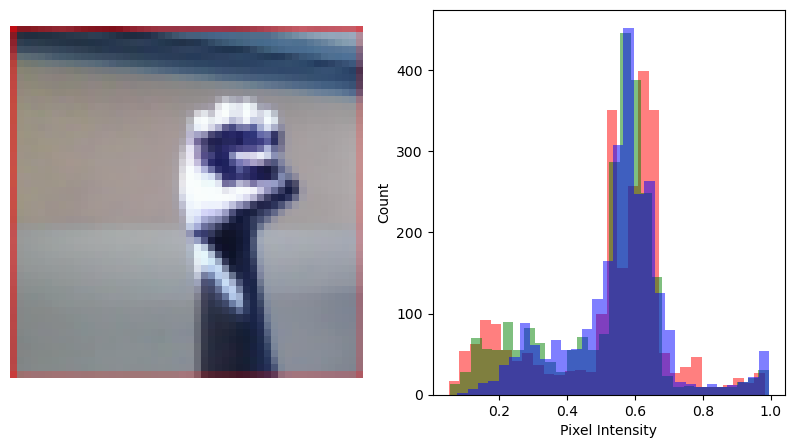

In [9]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

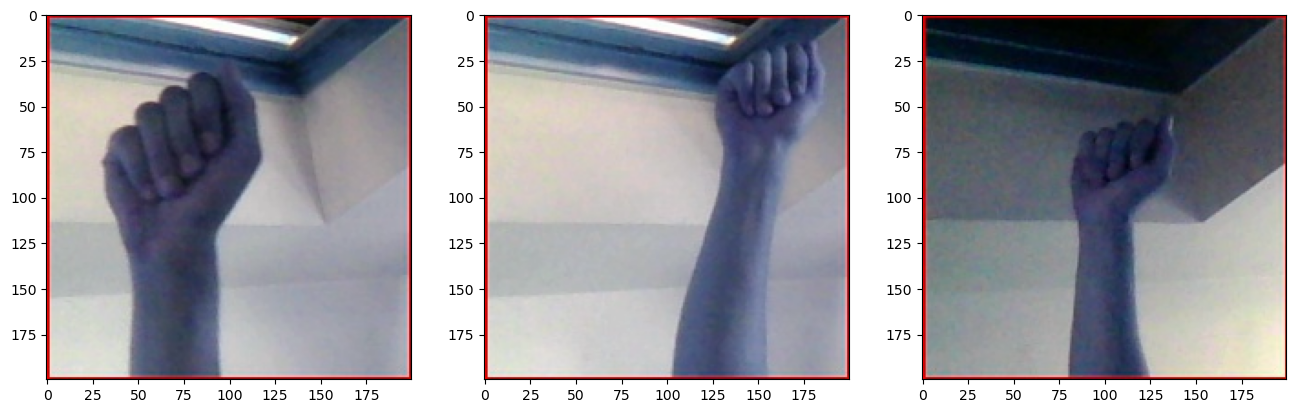

In [10]:
# 3 images from category "A"

multipleImages = glob('alpha_train/A/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]))
    #;
plotThreeImages(multipleImages)

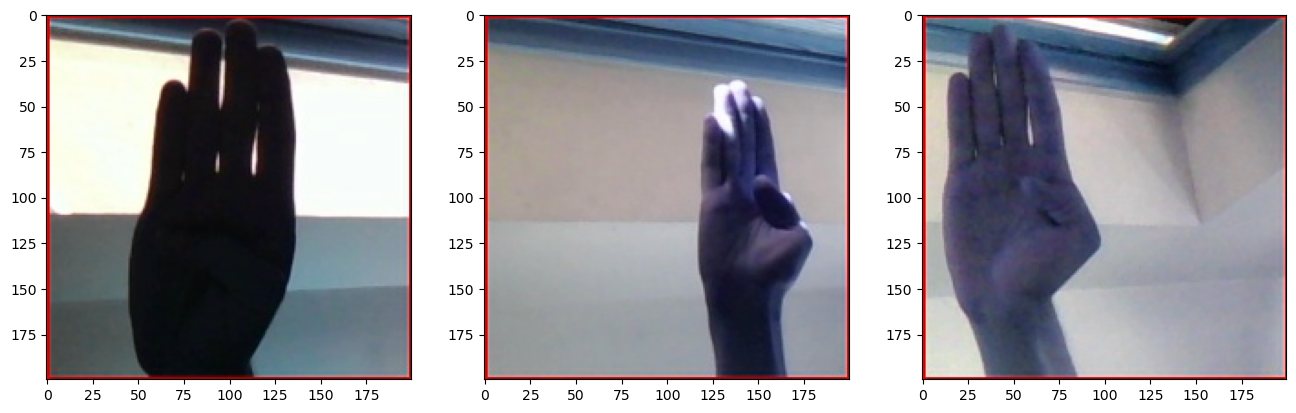

In [11]:
# 3 images from category "B"

multipleImages = glob('alpha_train/B/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])) 
plotThreeImages(multipleImages)

A


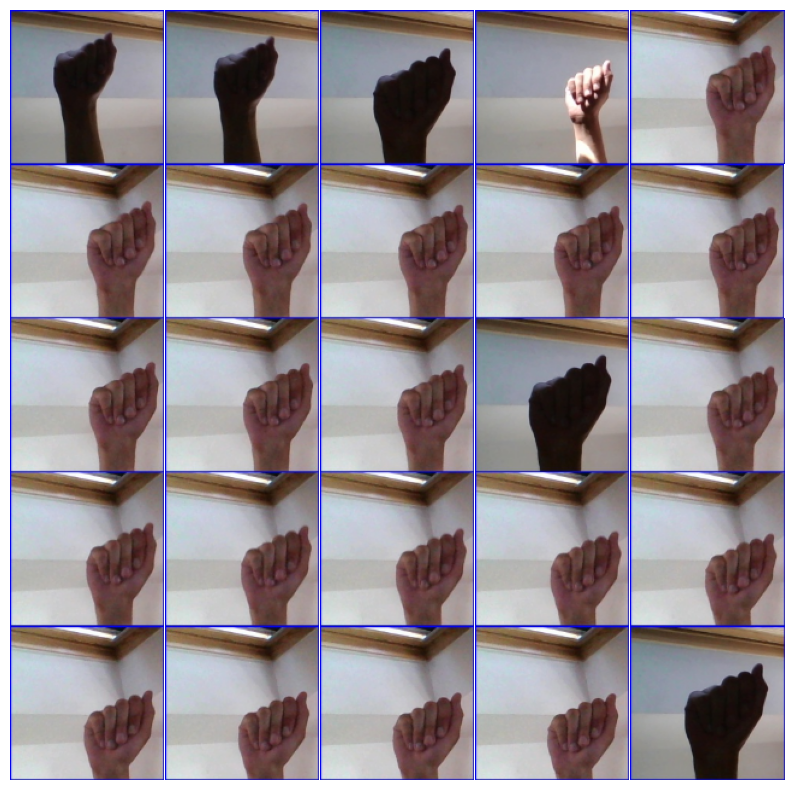

In [12]:
# 20 images from category "A"

print("A")
multipleImages = glob('alpha_train/A/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

B


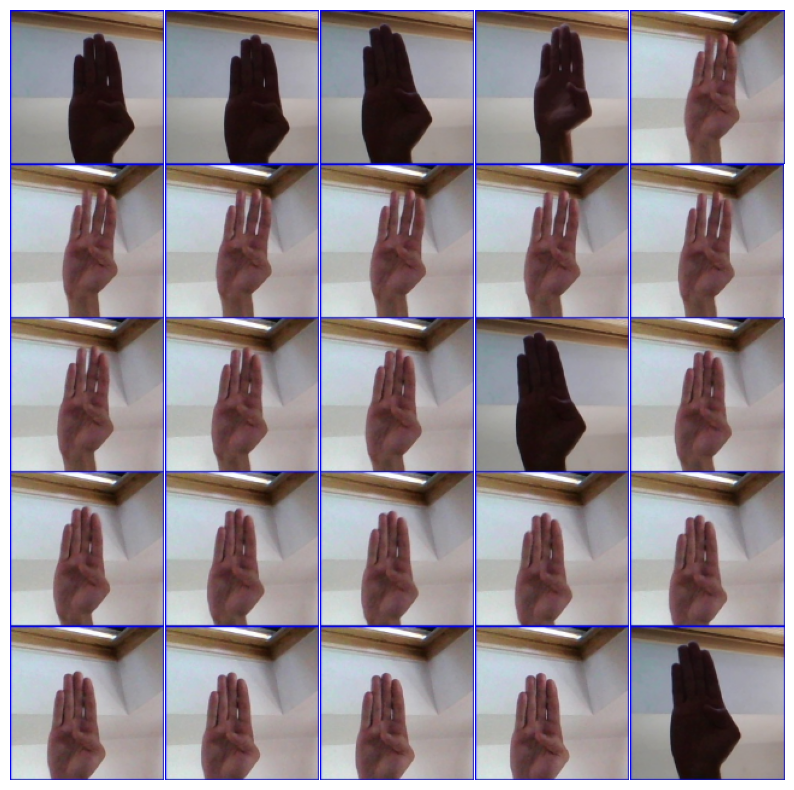

In [13]:
# 20 images from category "B"

print("B")
multipleImages = glob('alpha_train/B/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

C:\Users\harsh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space', 29: 'other'}


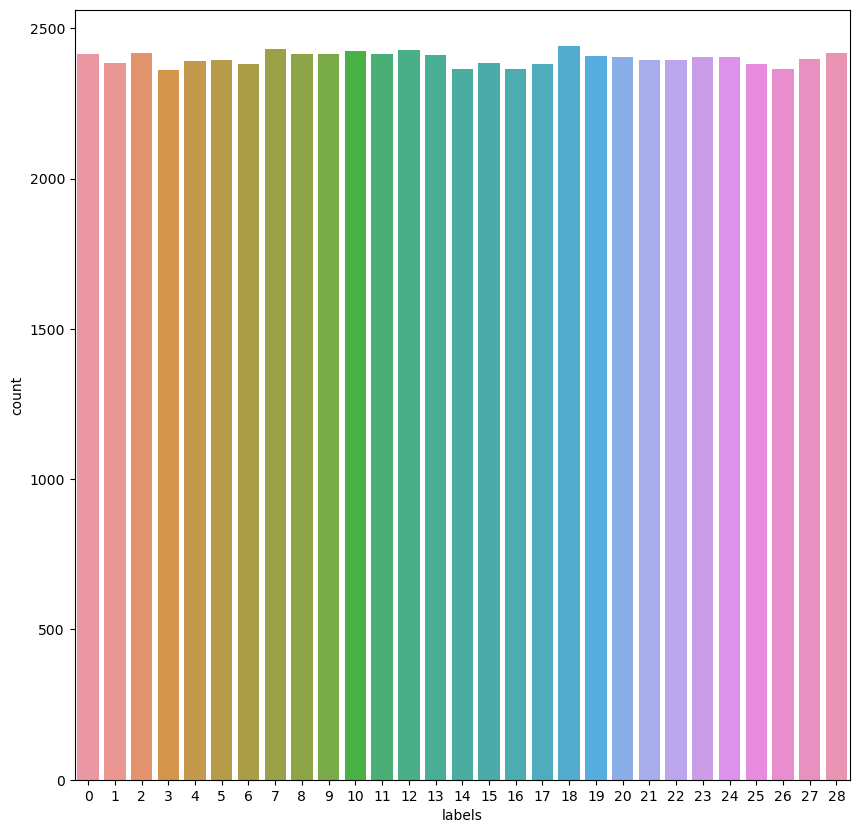

In [14]:
map_characters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space', 29: 'other'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

# Step 4: Define Helper Functions

In [15]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

# Step 5: Evaluate Classification Models

In [16]:
from sklearn.utils import class_weight

# Correct usage of compute_class_weight
class_weight1 = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


In [17]:
from sklearn.metrics import classification_report, confusion_matrix


In [18]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [19]:
map_characters1 = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P',
    16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
    24: 'Y', 25: 'Z', 26: 'Space', 27: 'Delete', 28: '0', 29: '1'
}


In [20]:
# Import required modules
import numpy as np
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.applications import VGG16
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Import class_weight utility if not already imported
from sklearn.utils import class_weight

# Other imports like MetricsCheckpoint, plotKerasLearningCurve, etc.


In [21]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.applications import VGG16
from keras import optimizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Compute class weights based on y_train
class_weight_dict = {0: 1.0, 1: 1.2, 2: 1.5}  # Example class weights, adjust as per actual data

# Define path to the pre-trained weights
weight_path1 = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the VGG16 model without the top layers
pretrained_model_1 = VGG16(weights=weight_path1, include_top=False, input_shape=(50, 50, 3))

# Define optimizers
optimizer1 = optimizers.Adam()

# Define the function for the pretrained network
def pretrainedNetwork(xtrain, ytrain, xtest, ytest, pretrainedmodel, classweight, numclasses, numepochs, optimizer):
    base_model = pretrainedmodel  # Use the topless model passed as a parameter
    
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    # Callbacks
    callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]
    
    model.summary()
    
    # Train the model with the class weights dictionary
    history = model.fit(
        xtrain, ytrain, 
        epochs=numepochs, 
        class_weight=classweight,  # Pass the class weights dictionary
        validation_data=(xtest, ytest), 
        verbose=1, 
        callbacks=callbacks_list  # Use EarlyStopping callback
    )
    
    # Return the trained model and the training history
    return model, history

# Assuming X_train, y_trainHot, X_test, y_testHot are preprocessed and ready
# Call the pretrainedNetwork function and store the returned model and history
model, history = pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot, pretrained_model_1, class_weight_dict, 30, 10, optimizer1)

# Show the training history (truncated for brevity)
print(history.history)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 50, 50, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │          15,390 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,730,078 (56.19 MB)

 Trainable params: 15,390 (60.12 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 289s 307ms/step - accuracy: 0.3378 - loss: 2.7425 - val_accuracy: 0.6677 - val_loss: 1.6194
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 310s 331ms/step - accuracy: 0.7110 - loss: 1.4883 - val_accuracy: 0.7572 - val_loss: 1.1717
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 317s 338ms/step - accuracy: 0.7865 - loss: 1.1142 - val_accuracy: 0.8115 - val_loss: 0.9429
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 324s 345ms/step - accuracy: 0.8227 - loss: 0.9023 - val_accuracy: 0.8365 - val_loss: 0.8026
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 317s 338ms/step - accuracy: 0.8474 - loss: 0.7778 - val_accuracy: 0.8526 - val_loss: 0.7035
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 322s 343ms/step - accuracy: 0.8687 - loss: 0.6671 - val_accuracy: 0.8747 - val_loss: 0.6235
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 329s 350ms/step - accuracy: 0.8825 - loss: 0.6034 - val_accuracy: 0.8841 - val_loss: 0.5674
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 326s 347ms/step - accuracy: 0.8921 -

predicting classes:

544/544 ━━━━━━━━━━━━━━━━━━━━ 104s 187ms/step

              precision    recall  f1-score   support

     Class_0       0.94      0.85      0.89       585
     Class_1       0.79      0.97      0.87       615
     Class_2       0.98      0.99      0.98       581
     Class_3       0.97      0.98      0.97       638
     Class_4       0.90      0.84      0.87       607
     Class_5       0.98      0.96      0.97       604
     Class_6       0.97      0.95      0.96       620
     Class_7       0.98      0.97      0.97       570
     Class_8       0.92      0.91      0.91       586
     Class_9       0.97      0.97      0.97       584
    Class_10       0.92      0.83      0.88       575
    Class_11       0.96      0.99      0.97       585
    Class_12       0.87      0.85      0.86       573
    Class_13       0.89      0.87      0.88       589
    Class_14       0.98      0.93      0.95       636
    Class_15       0.92      0.97      0.94       614
    Class_16  

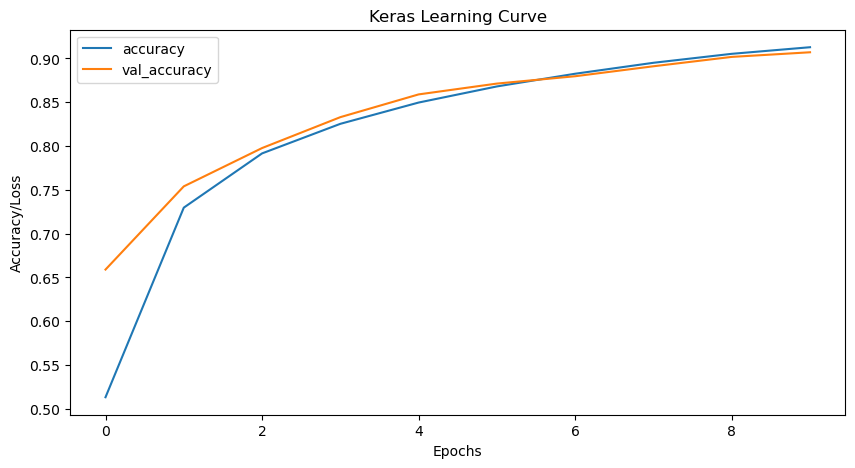

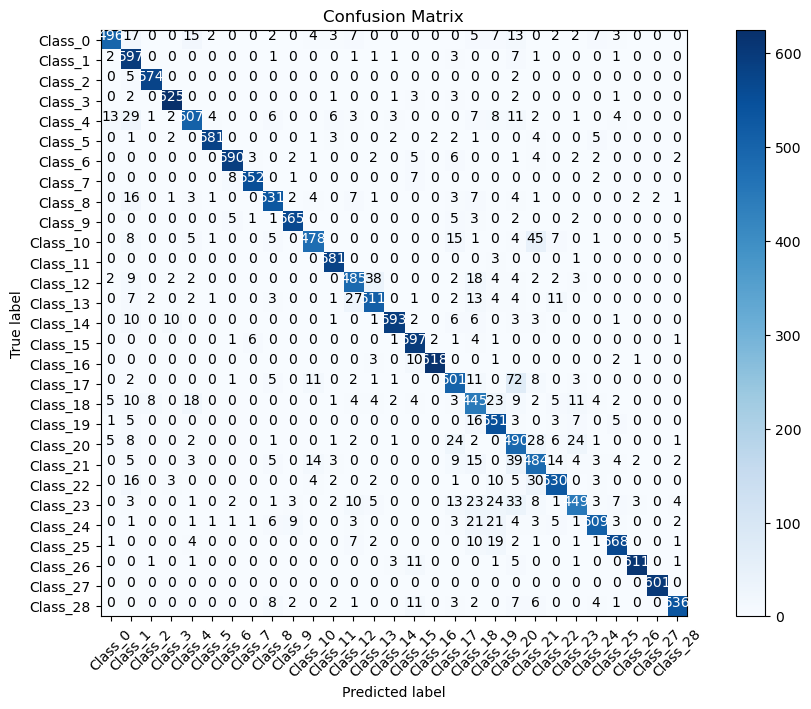

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot Keras learning curve
def plotKerasLearningCurve():
    plt.figure(figsize=(10, 5))
    # Load the metrics with allow_pickle=True
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc']  # Filter for accuracy
    for k in filter(lambda x: np.any([kk in x for kk in filt]), metrics.keys()):
        plt.plot(metrics[k], label=k)
    plt.legend(loc='best')
    plt.title('Keras Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy/Loss')
    
# Predict the classes for the test data
print("predicting classes:\n")
y_pred = model.predict(X_test)

# Check if the number of classes in your dataset is correct
num_classes = 29  # Set to the correct number of classes in your dataset

# Ensure that the target names match the number of classes
if len(map_characters1) != num_classes:
    map_characters1 = {i: f"Class_{i}" for i in range(num_classes)}  # Adjust map_characters1

# Print classification report with correct number of classes
print('\n', classification_report(np.argmax(y_testHot, axis=1), np.argmax(y_pred, axis=1), target_names=list(map_characters1.values())), sep='')

# Confusion matrix
Y_pred_classes = np.argmax(y_pred, axis=1)
Y_true = np.argmax(y_testHot, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plotting learning curves and confusion matrix
plotKerasLearningCurve()
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(confusion_mtx, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = confusion_mtx.max() / 2.
    for i, j in np.ndindex(confusion_mtx.shape):
        plt.text(j, i, format(confusion_mtx[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, classes=list(map_characters1.values()))
plt.show()


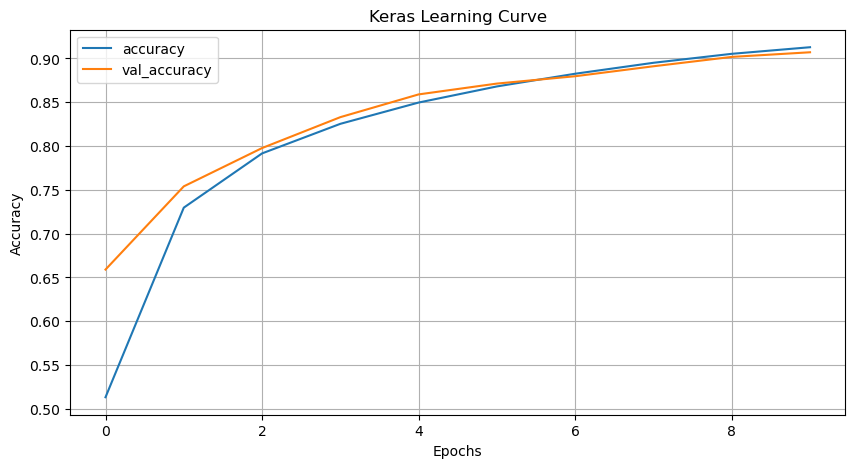

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot Keras learning curve
def plotKerasLearningCurve():
    plt.figure(figsize=(10, 5))
    # Load the metrics from logs.npy with allow_pickle=True
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc']  # Filter for accuracy (or 'loss' for loss curves)
    
    # Plot each filtered metric
    for k in filter(lambda x: np.any([kk in x for kk in filt]), metrics.keys()):
        plt.plot(metrics[k], label=k)
    
    # Display the plot legend and grid
    plt.legend()
    plt.grid(True)
    plt.title('Keras Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

# Call the function to plot the learning curve
plotKerasLearningCurve()

# Show the plot after calling the function
plt.show()


In [24]:
import os
print(os.path.exists('logs.npy'))


True


In [25]:
data = np.load('logs.npy', allow_pickle=True)
print(data)


{'accuracy': [0.5131999850273132, 0.7296666502952576, 0.7915999889373779, 0.8253666758537292, 0.8496666550636292, 0.868066668510437, 0.8825666904449463, 0.8950666785240173, 0.9053000211715698, 0.9128333330154419], 'loss': [2.222116231918335, 1.3553897142410278, 1.0405082702636719, 0.8620474338531494, 0.7419087290763855, 0.6535862684249878, 0.586349606513977, 0.5311496257781982, 0.48710453510284424, 0.449832946062088], 'val_accuracy': [0.658965528011322, 0.7539654970169067, 0.7977011203765869, 0.8329885005950928, 0.8589655160903931, 0.8713218569755554, 0.8797126412391663, 0.8910919427871704, 0.9017816185951233, 0.9070689678192139], 'val_loss': [1.6277337074279785, 1.1878653764724731, 0.9568731188774109, 0.8146212697029114, 0.7139849066734314, 0.6329771280288696, 0.5758265852928162, 0.5311433672904968, 0.48728498816490173, 0.4535205364227295]}


In [26]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10, 5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    print(metrics)  # Print metrics to verify content
    for k in metrics.keys():
        plt.plot(metrics[k], label=k)
    plt.legend()
    plt.grid(True)


In [27]:
# Assuming 'history' contains the training history
np.save('logs.npy', history.history)


{'accuracy': [0.5000333189964294, 0.7332666516304016, 0.7943000197410583, 0.8271666765213013, 0.8520333170890808, 0.8691999912261963, 0.883566677570343, 0.8942000269889832, 0.9041000008583069, 0.9111999869346619], 'loss': [2.2622714042663574, 1.375597357749939, 1.0550371408462524, 0.8721322417259216, 0.7510599493980408, 0.6607664227485657, 0.5922079682350159, 0.537691593170166, 0.49215131998062134, 0.45431044697761536], 'val_accuracy': [0.6677011251449585, 0.7571839094161987, 0.8114942312240601, 0.8364942669868469, 0.8525862097740173, 0.8747126460075378, 0.8840804696083069, 0.8958045840263367, 0.9021264314651489, 0.9055172204971313], 'val_loss': [1.6194475889205933, 1.1716893911361694, 0.9429051876068115, 0.8025645017623901, 0.7034932971000671, 0.6235251426696777, 0.5673888921737671, 0.5180963277816772, 0.4810829758644104, 0.4483928978443146]}


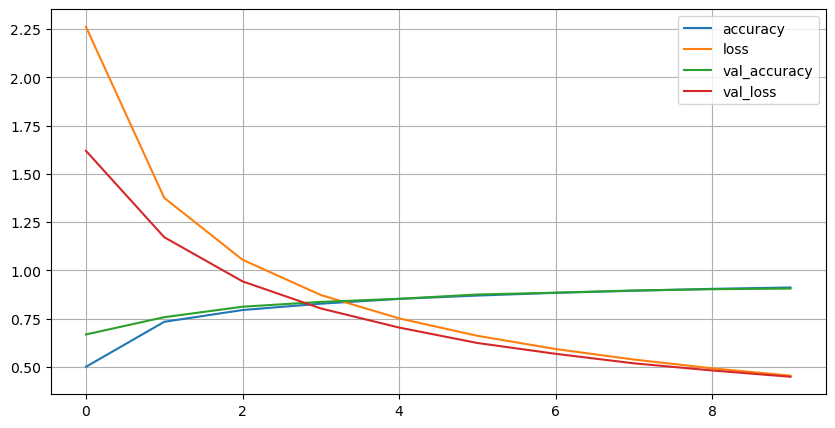

In [28]:
plotKerasLearningCurve()
plt.show()


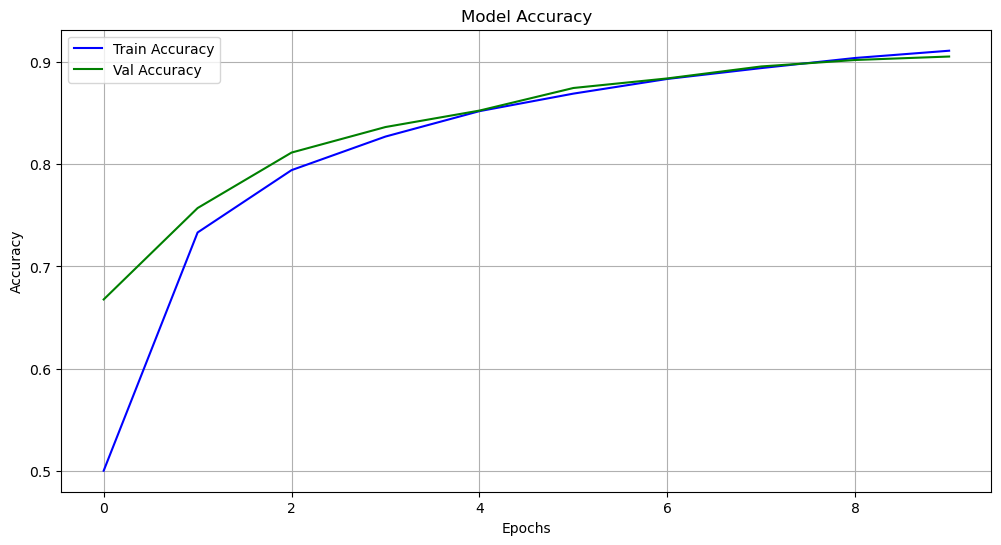

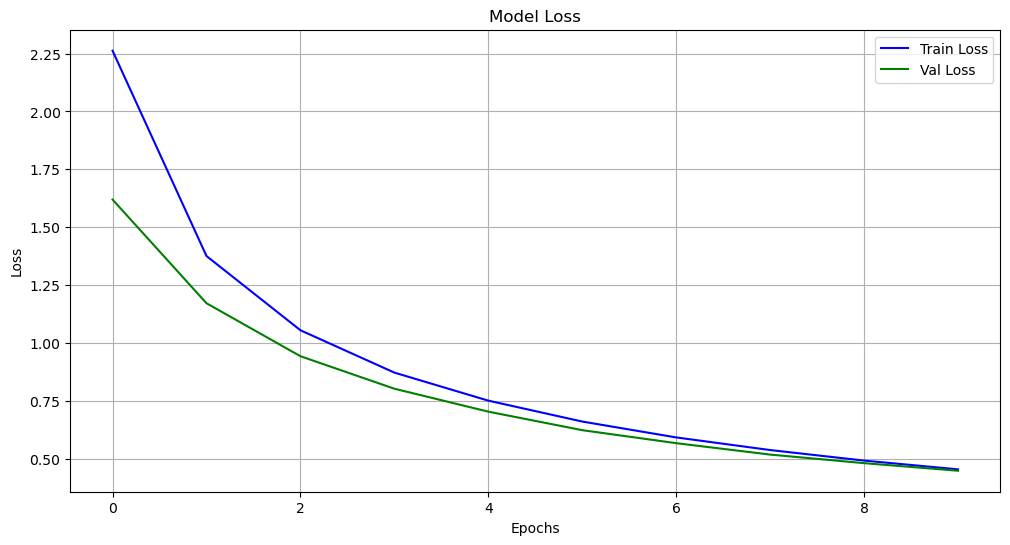

In [29]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_accuracy_loss(history):
    # Plot Training & Validation Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='green')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Plot Training & Validation Loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='green')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Add this line after training ends to call the function
plot_accuracy_loss(history)


In [30]:
print(y_test.shape)
print(np.max(y_test))  # Check if the values are in one-hot encoded format (0,1 values) or integer labels


(17400,)
28


In [31]:
Y_true = y_test  # No need for np.argmax


Confusion Matrix:
[[2 0 1]
 [1 1 1]
 [0 1 1]]

Labels:
['A', 'B', 'C']


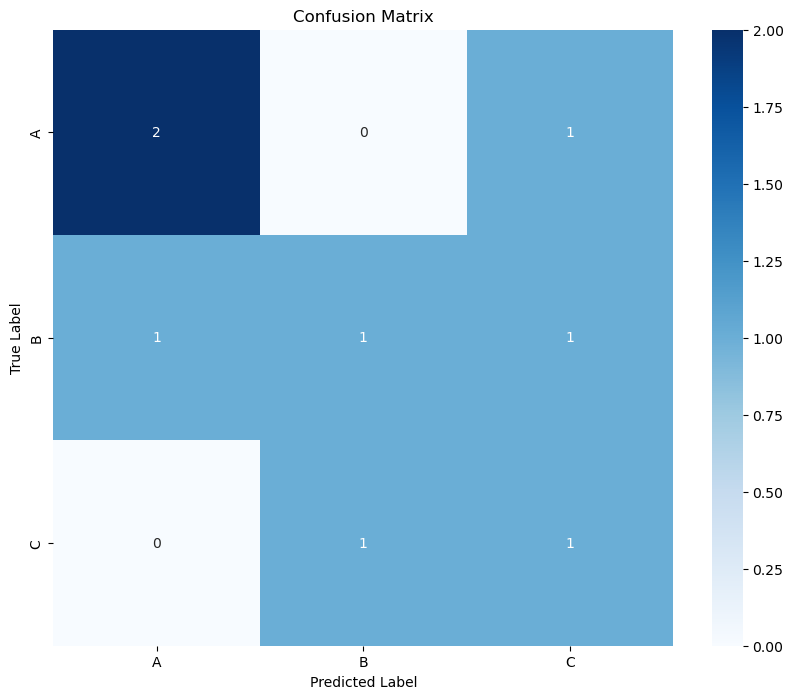

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the function to plot the confusion matrix heatmap
def plot_confusion_matrix_heatmap(conf_matrix, labels):
    if conf_matrix.size == 0:
        print("Confusion matrix is empty. Please check the data.")
        return

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Replace these with actual values from your model's predictions and the true labels
y_true = [0, 1, 2, 0, 1, 2, 1, 0]  # Actual labels (example, replace with actual dataset)
y_pred = [0, 1, 2, 2, 0, 1, 2, 0]  # Predictions made by the model (example, replace with actual predictions)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Ensure 'map_characters1' is populated correctly
# Assuming map_characters1 is a dictionary mapping indices to class labels
map_characters1 = {0: 'A', 1: 'B', 2: 'C'}  # Example mapping (replace with your actual dictionary)
labels = list(map_characters1.values())

# Debug: print confusion matrix and labels to check if they match
print("Confusion Matrix:")
print(conf_matrix)
print("\nLabels:")
print(labels)

# Check if the confusion matrix is non-empty and has valid dimensions
if conf_matrix.size == 0 or conf_matrix.shape[0] != len(labels):
    print("Confusion matrix is either empty or the dimensions don't match with the labels.")
else:
    # Plot the confusion matrix
    plot_confusion_matrix_heatmap(conf_matrix, labels)


# Image to Letter

In [39]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [40]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

In [42]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define the class labels (ensure you have exactly 30 labels if your model has 30 output classes)
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'other_class_1', 'other_class_2', 'other_class_3', 'other_class_4']

# Path to your trained model (update with your correct model path)
model_path = 'best_model.keras'

# Load your trained model
model = load_model(model_path)

# Define a function to preprocess the input image
def preprocess_image(img_path, target_size=(50, 50)):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Add an extra dimension to make it (1, 50, 50, 3)
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image (normalization or scaling)
    img_array = preprocess_input(img_array)
    return img_array

# Define the function to predict the letter from the image
def predict_letter(img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)
    
    # Get the model prediction
    predictions = model.predict(img_array)
    
    # Get the predicted class index
    predicted_class = np.argmax(predictions)
    
    # Get the predicted letter or class name from the class_labels
    predicted_letter = class_labels[predicted_class]
    
    return predicted_letter

# Example usage: Provide the image path
img_path = 'immg3l.png'  # Replace with the actual image path

# Get the predicted letter
predicted_letter = predict_letter(img_path)

# Print the result
print(f'Predicted letter: {predicted_letter}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Predicted letter: L


-----------------------------------------------------------------------------------------THANK YOU--------------------------------------------------------------------------------------------------------